In [107]:
import pandas as pd
import numpy as np
import torch
import random
import pickle
import matplotlib.pyplot as plt
from collections import Counter

In [108]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_gpt2 = GPT2LMHeadModel.from_pretrained('gpt2', output_attentions = True)
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
#heads with accuracy being higher than 70%
pl_heads = {0:[1,5,10],1:[5,6,11],3:[0],4:[4,10], 5:[10,11], 6:[6],7:[1,9], 8:[3,10],9:[4], 10:[7]}
model_gpt2.prune_heads(pl_heads)

In [109]:
def calculate_surprisal(sentence, target_word, model, tokenizer):
    """
    Calculate the surprisal of a target word within a given sentence using a specified model and tokenizer.
    
    Parameters:
        sentence (str): The sentence within which the word exists.
        target_word (str): The specific word whose surprisal to be calculated.
        model (torch.nn.Module): The PyTorch model used for prediction.
        tokenizer: The tokenizer used for word tokenization.

    Returns:
        surprisal_value (float): The surprisal of the target word.
    """  


    # Tokenize the sentence
    indexed_tokens = tokenizer.encode(sentence)
    tokens = [tokenizer.decode(index).strip().replace(' ','') for index in indexed_tokens]


    # Also move the model to the same device
    #model.to(device)
    if(target_word in tokens):
    
        # Locate the target word within the tokens
        target_word_location = tokens.index(target_word)

        # Index the token prefixes up to the target word location
        prefix_index = indexed_tokens[:target_word_location]

        # Convert the prefix tokens to tensor and move the tensor to device
        prefix_tensor = torch.tensor([prefix_index])

    # Make predictions with the model while excluding gradient computation
        with torch.no_grad():
            output = model(prefix_tensor)
            predictions = torch.nn.functional.softmax(output[0], dim=-1)
            prediction_result = predictions[0, -1, :]
        
            # Calculate the surprisal of the target word
            score_of_target_word = prediction_result[indexed_tokens[target_word_location]]
            surprisal_of_target_word = -torch.log2(score_of_target_word).numpy()

        return float(surprisal_of_target_word)
    else:
        return None;

In [110]:
cunnings = pd.read_csv('cunnings2018.csv')

## 5.1. Influence of a set of plausibility-processing heads to plausibility sensitivity

In [111]:
_id = np.unique(cunnings["id"])
cunnings['layer']=None
cunnings['head']=None
pl_effects = torch.zeros(12,12)
acc = torch.zeros(12,12)

for i in _id:
    _set = cunnings[cunnings['id']==i]
    plpl_sent = _set[_set['cond']=='pl_pl'].sent.item()
    plimpl_sent = _set[_set['cond']=='pl_impl'].sent.item()
    implpl_sent = _set[_set['cond']=='impl_pl'].sent.item()
    implimpl_sent = _set[_set['cond']=='impl_impl'].sent.item()
    
    pl_subj = _set[_set['cond']=='pl_impl'].subj.item()
    impl_subj = _set[_set['cond']=='impl_impl'].subj.item()
    pl_dist = _set[_set['cond']=='pl_pl'].dist.item()
    impl_dist = _set[_set['cond']=='pl_impl'].dist.item()
    
    verb = _set[_set['cond']=='pl_impl'].verb.item()
    
    plpl_indexed_tokens = tokenizer_gpt2.encode(plpl_sent)
    plpl_tokens = [tokenizer_gpt2.decode(i).strip() for i in plpl_indexed_tokens]
    implimpl_indexed_tokens = tokenizer_gpt2.encode(implimpl_sent)
    implimpl_tokens = [tokenizer_gpt2.decode(i).strip() for i in implimpl_indexed_tokens]
    
    
    if verb in plpl_tokens:
        plpl_surprisal = calculate_surprisal(plpl_sent, verb, model_gpt2, tokenizer_gpt2)
        plimpl_surprisal = calculate_surprisal(plimpl_sent, verb, model_gpt2, tokenizer_gpt2)
        implpl_surprisal = calculate_surprisal(implpl_sent, verb, model_gpt2, tokenizer_gpt2)
        implimpl_surprisal = calculate_surprisal(implimpl_sent, verb, model_gpt2, tokenizer_gpt2)
        
        cunnings.loc[(cunnings['id'] == id) & (cunnings['cond'] == 'pl_pl'), 'surprisal_heads_pruned']  = plpl_surprisal
        cunnings.loc[(cunnings['id'] == id) & (cunnings['cond'] == 'impl_pl'), 'surprisal_heads_pruned']  = implpl_surprisal
        cunnings.loc[(cunnings['id'] == id) & (cunnings['cond'] == 'pl_impl'), 'surprisal_heads_pruned']  = plimpl_surprisal
        cunnings.loc[(cunnings['id'] == id) & (cunnings['cond'] == 'impl_impl'), 'surprisal_heads_pruned'] = implimpl_surprisal

In [112]:
all_heads=[(i,j) for i in range(12) for j in range(12)]
cunnings['surprisal_heads_pruned_random']=np.zeros(128)
#cunnings = pd.read_csv('cunnings.csv')
for t in range(100):
    rand_07=random.sample(all_heads, k=19)
    lh_dict =dict()
    for l,h in rand_07:
        if l in lh_dict:
            lh_dict[l].append(h)
        else:
            lh_dict[l]=[h]

    gpt_pruned = GPT2LMHeadModel.from_pretrained('gpt2', output_attentions = True)
    gpt_pruned.prune_heads(lh_dict)

    _id = np.unique(cunnings["id"])
    
    cunnings['layer']=None
    cunnings['head']=None

    for i in _id:
        _set = cunnings[cunnings['id']==i]
        plpl_sent = _set[_set['cond']=='pl_pl'].sent.item()
        plimpl_sent = _set[_set['cond']=='pl_impl'].sent.item()
        implpl_sent = _set[_set['cond']=='impl_pl'].sent.item()
        implimpl_sent = _set[_set['cond']=='impl_impl'].sent.item()
    
        pl_subj = _set[_set['cond']=='pl_impl'].subj.item()
        impl_subj = _set[_set['cond']=='impl_impl'].subj.item()
        pl_dist = _set[_set['cond']=='pl_pl'].dist.item()
        impl_dist = _set[_set['cond']=='pl_impl'].dist.item()
    
        verb = _set[_set['cond']=='pl_impl'].verb.item()
    
        plpl_indexed_tokens = tokenizer_gpt2.encode(plpl_sent)
        plpl_tokens = [tokenizer_gpt2.decode(i).strip() for i in plpl_indexed_tokens]
        implimpl_indexed_tokens = tokenizer_gpt2.encode(implimpl_sent)
        implimpl_tokens = [tokenizer_gpt2.decode(i).strip() for i in implimpl_indexed_tokens]
    
        if verb in plpl_tokens:
            plpl_surprisal = calculate_surprisal(plpl_sent, verb, gpt_pruned, tokenizer_gpt2)
            plimpl_surprisal = calculate_surprisal(plimpl_sent, verb, gpt_pruned, tokenizer_gpt2)
            implpl_surprisal = calculate_surprisal(implpl_sent, verb, gpt_pruned, tokenizer_gpt2)
            implimpl_surprisal = calculate_surprisal(implimpl_sent, verb, gpt_pruned, tokenizer_gpt2)
            
            cunnings.loc[(cunnings['id'] == i) & (cunnings['cond'] == 'pl_pl'), 'surprisal_heads_pruned_random']+= plpl_surprisal
            cunnings.loc[(cunnings['id'] == i) & (cunnings['cond'] == 'impl_pl'), 'surprisal_heads_pruned_random']  += implpl_surprisal
            cunnings.loc[(cunnings['id'] == i) & (cunnings['cond'] == 'pl_impl'), 'surprisal_heads_pruned_random'] += plimpl_surprisal
            cunnings.loc[(cunnings['id'] == i) & (cunnings['cond'] == 'impl_impl'), 'surprisal_heads_pruned_random'] += implimpl_surprisal

## 5.2. Gradual changes in GPT2’s plausibility sensitivity as attention heads are pruned

In [113]:

# Attention heads sorted with their accuracies (saved in section 3)
acc_dict = pickle.load(open("heads_sorted_by_acc.p", "rb"))
acc_dict = [i for i in acc_dict if i[1] > 0.75]

In [114]:
plpl_surprisal_all, plimpl_surprisal_all, implpl_surprisal_all, implimpl_surprisal_all  = [], [], [], []

for remove_num in range(len(acc_dict)+1):
        model = GPT2LMHeadModel.from_pretrained('gpt2', output_attentions = True)
        rem_heads = [i[0] for i in acc_dict[:remove_num]]
        lh_dict =dict()
        for l,h in rem_heads:
            if l in lh_dict:
                lh_dict[l].append(h)
            else:
                lh_dict[l]=[h]
        model.prune_heads(lh_dict)

        _id = np.unique(cunnings["id"])
        plpl_surprisal, plimpl_surprisal, implpl_surprisal, implimpl_surprisal = 0,0,0,0
        num = 0

        for i in _id:
            _set = cunnings[cunnings['id']==i]
            plpl_sent = _set[_set['cond']=='pl_pl'].sent.item()
            plimpl_sent = _set[_set['cond']=='pl_impl'].sent.item()
            implpl_sent = _set[_set['cond']=='impl_pl'].sent.item()
            implimpl_sent = _set[_set['cond']=='impl_impl'].sent.item()
    
            pl_subj = _set[_set['cond']=='pl_impl'].subj.item()
            impl_subj = _set[_set['cond']=='impl_impl'].subj.item()
            pl_dist = _set[_set['cond']=='pl_pl'].dist.item()
            impl_dist = _set[_set['cond']=='pl_impl'].dist.item()
    
            verb = _set[_set['cond']=='pl_impl'].verb.item()
    
            plpl_indexed_tokens = tokenizer_gpt2.encode(plpl_sent)
            plpl_tokens = [tokenizer_gpt2.decode(i).strip() for i in plpl_indexed_tokens]
            implimpl_indexed_tokens = tokenizer_gpt2.encode(implimpl_sent)
            implimpl_tokens = [tokenizer_gpt2.decode(i).strip() for i in implimpl_indexed_tokens]
            #print(implimpl_tokens,plpl_tokens)
            
            if verb in plpl_tokens:
                plpl_surprisal += calculate_surprisal(plpl_sent, verb, model, tokenizer_gpt2)
                plimpl_surprisal += calculate_surprisal(plimpl_sent, verb, model, tokenizer_gpt2)
                implpl_surprisal += calculate_surprisal(implpl_sent, verb, model, tokenizer_gpt2)
                implimpl_surprisal += calculate_surprisal(implimpl_sent,verb, model, tokenizer_gpt2)
                num+=1
            
        plpl_surprisal_all.append(plpl_surprisal/num)
        plimpl_surprisal_all.append(plimpl_surprisal/num)
        implpl_surprisal_all.append(implpl_surprisal/num)
        implimpl_surprisal_all.append(implimpl_surprisal/num)
                

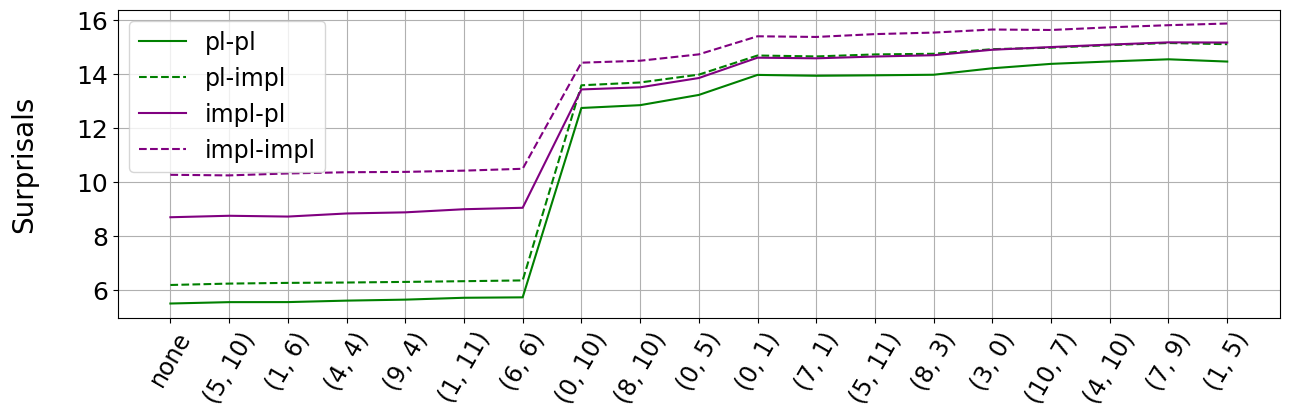

In [122]:
heads_list = [str(i[0]) for i in acc_dict][:19]
heads_list.insert(0,'none')
plt.figure(figsize=(15,4))
plt.plot(heads_list, plpl_surprisal_all, color = 'green',label='pl-pl')
plt.plot(heads_list, plimpl_surprisal_all,'--', color = 'green', label='pl-impl')
plt.plot(heads_list, implpl_surprisal_all, color = 'purple',label='impl-pl')
plt.plot(heads_list, implimpl_surprisal_all,'--', color ='purple',label='impl-impl')

plt.grid(True) # Add grid
plt.legend(fontsize=17)
plt.yticks(fontsize=18)
plt.ylabel('Surprisals\n', fontsize = 20)
plt.xticks(rotation=60,fontsize=17)
plt.show()
#plt.savefig('graphs/gradual-pruning.png')

In [116]:
effects_dep = np.array(implpl_surprisal_all[:19])+np.array(implimpl_surprisal_all[:19])-np.array(plpl_surprisal_all[:19])-np.array(plimpl_surprisal_all[:19])
effects_dist = np.array(plimpl_surprisal_all[:19])+np.array(implimpl_surprisal_all[:19])-np.array(plpl_surprisal_all[:19])-np.array(implpl_surprisal_all[:19])
effects_norm = [sum(x)/2 for x in zip(effects_dep,effects_dist)]

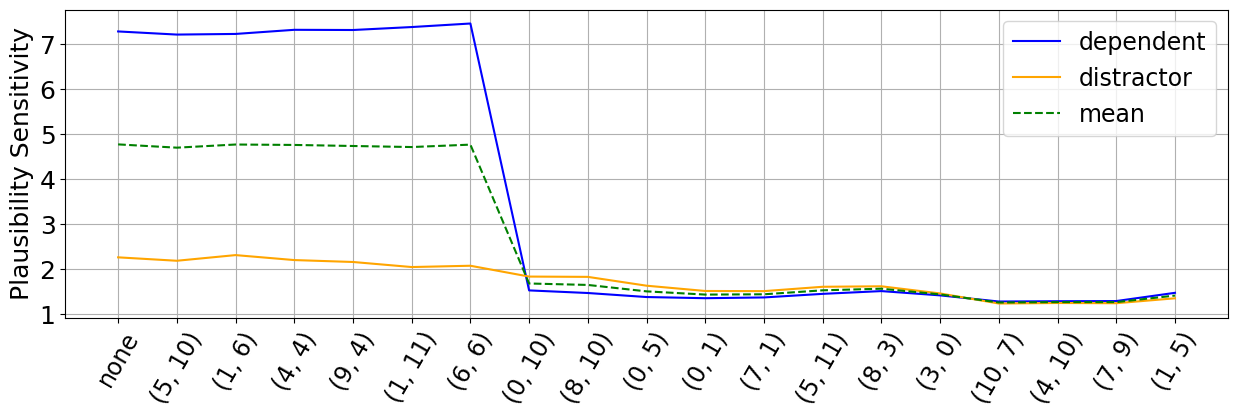

In [124]:
plt.figure(figsize=(15,4))

# Use explicit keyword arguments for line properties
plt.plot(heads_list, effects_dep, linestyle='-', color='blue', label='dependent')
plt.plot(heads_list, effects_dist, linestyle='-', color='orange', label='distractor')
plt.plot(heads_list, effects_norm, linestyle='--', color='green', label='mean')

plt.ylabel('Plausibility Sensitivity', fontsize=18)

plt.xticks(rotation=60, fontsize=17)
plt.yticks(fontsize=18)

plt.grid(True) # Add grid
plt.legend(fontsize=17)
plt.savefig('gradual-pruning.png')
plt.show()

## 5.3 Perplexity Analysis

In [88]:
def get_perplexity(sent_set, model, tokenizer, device):
    num_words = 0
    surprisal_sum = 0
    for sent in sent_set:
        indexed_tokens = tokenizer.encode(sent)
        tokens = [tokenizer.decode(i).strip() for i in indexed_tokens]
        num_words += len(tokens)
        for idx in range(1, len(tokens)):
            prefix_index = indexed_tokens[:idx]
            prefix_tensor = torch.tensor([prefix_index])
            prefix_tensor = prefix_tensor.to(device)
            model.to(device)
            with torch.no_grad():
                output= model(prefix_tensor)
                predictions = torch.nn.functional.softmax(output[0],-1)
                result = predictions[0,-1,:]
                score_current_w = result[indexed_tokens[idx]]
                surprisal_current_w = -1*torch.log2(score_current_w)
                surprisal_current_w = surprisal_current_w.numpy()
            surprisal_sum += surprisal_current_w

    return surprisal_sum/num_words

In [92]:
story = open("moneybox.txt", "r")
story = story.read()
story=[i[:-1] for i in story.split('\n') if len(i)>1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [118]:
dataset = np.zeros((12,12))
for l in range(12):
    for h in range(12):
        model = GPT2LMHeadModel.from_pretrained('gpt2', output_attentions = True)
        #print('='*20)
        #print('{}_{}head is pruned.'.format(l,h))
        model.prune_heads({l:[h]})
        perplexity = round(get_perplexity(story,model,tokenizer_gpt2, device),2)
        #print("perplexity: " +str(perplexity))
        dataset[l][h] = perplexity

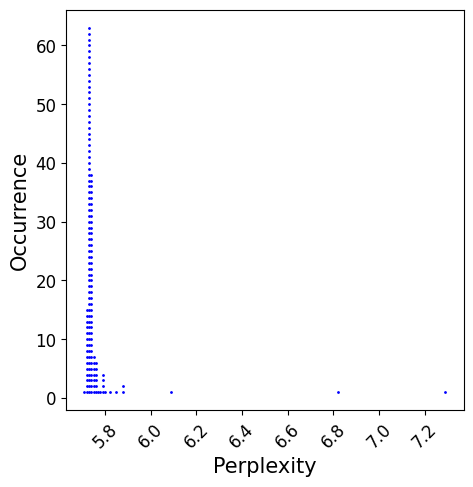

In [119]:
import plotly.graph_objects as go
ak = []
for i in dataset:
    ak+=list(i)
z = Counter(ak)
ar = 1
fig, ax = plt.subplots(figsize=(plt.figaspect(ar)))
for key, value in z.items():
    X = [key] * value
    Y = [item + 1 for item in range(value)]
    plt.scatter(X, Y, color='b', s=1)

plt.xlabel('Perplexity',fontsize = 15)
plt.ylabel('Occurrence', fontsize=15)
#plt.title('Histogram of GPT2 perplexity\n after removing a single head', fontsize = 14)
plt.tight_layout()
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.savefig('perplexity.png')